# Package & Data Import

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import datetime as dt

# Part 1: Exploratory Data Analysis

In [2]:
logins = pd.read_json("logins.json") #import data
logins.set_index('login_time', inplace=True) #set the login time as the index
logins.sort_index(inplace=True) #sort the login times
logins['logins'] = 1 #create a single login count for each time stamp
logins.index = pd.to_datetime(logins.index)

Now that the data has been imported, the logins need to be grouped into 15 minute windows and counted. Afterwards we will need to look at the summary statistics and determine if there are any issues with the data.

In [3]:
ct = logins.index[0]
td = dt.timedelta(minutes=15)
more_time = True
agg15_count = []

while more_time:
    greater = logins.index >= ct
    lesser = logins.index < ct+td 
    cb_count = sum(greater == lesser) #current 15 minute bucket count
    agg15_count.append([ct + dt.timedelta(minutes=7, seconds=30), cb_count])
    ct = ct + td #update the current time
    if ct > logins.index[-1]:
        more_time = False

In [4]:
agg15_df = pd.DataFrame(agg15_count, columns = ['timestamp', 'logins'])
agg15_df.set_index('timestamp', inplace=True)

In [5]:
# Decided to bucket instead of using a rolling window
#agg15 = logins.rolling('15T', min_periods=1) #roll the logins into 15 minute time periods
#agg15_count = agg15.count() #get a count of the logins in a 15 minute window

In [6]:
# 15 minute window login count summary statistics
agg15_df.describe()

,logins
count,9788.000000
mean,9.515938
std,8.353281
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,71.000000


In [7]:
# determine if any logins are empty
# - should be none since each timestamp was given the value 1
agg15_df.isnull().sum()

logins    0
dtype: int64

There does not seem to be any issues with the count, but one thing to note is that the year is most likely wrong. Although possible, it is unlikely that the logins occured in 1970.

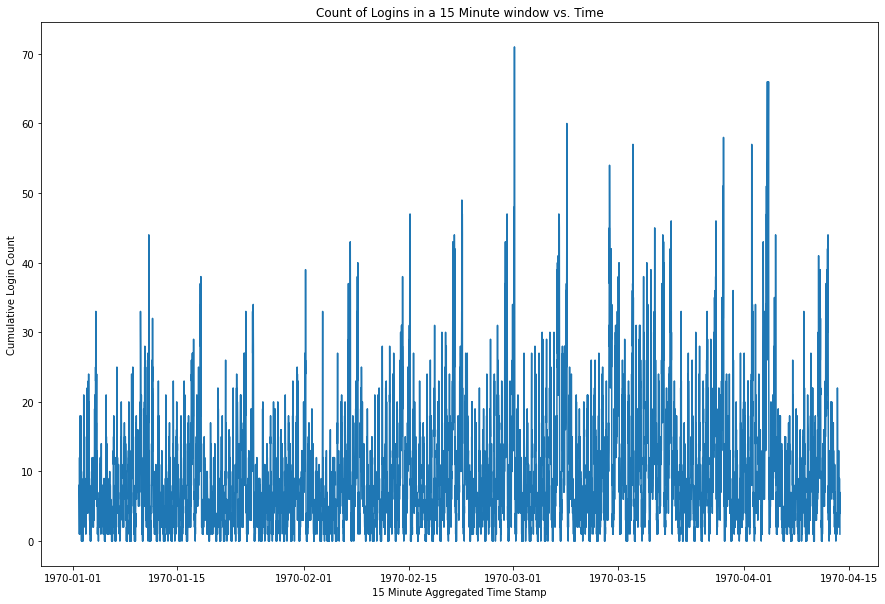

In [8]:
#Display all 15 minute values
fig = plt.figure(figsize=(15,10))
plt.plot(agg15_df.index, agg15_df.logins)
plt.xlabel('15 Minute Aggregated Time Stamp')
plt.ylabel('Cumulative Login Count')
plt.title('Count of Logins in a 15 Minute window vs. Time')

plt.show()

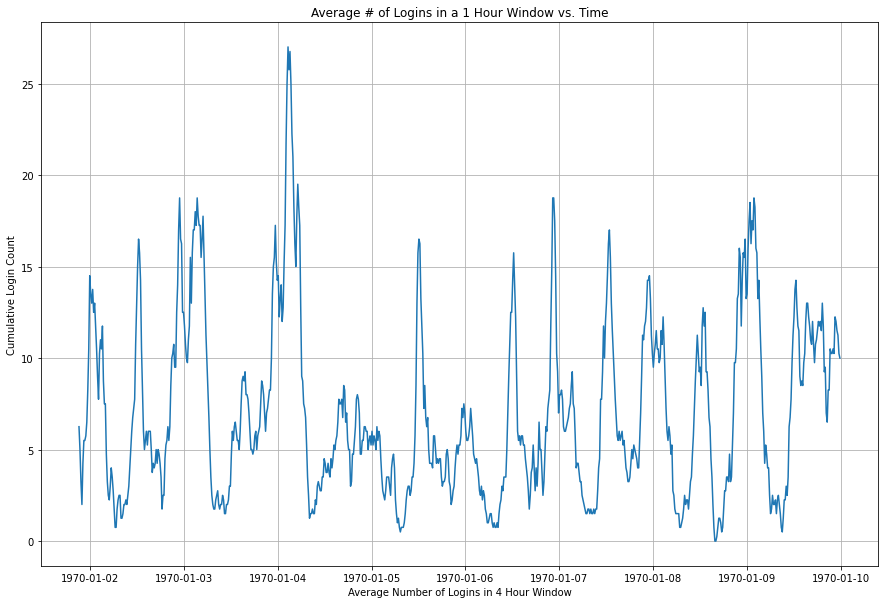

In [9]:
hourly_avg = agg15_df.rolling(4).mean()
hourly_avg = hourly_avg['1970-01-01': '1970-01-09']

fig = plt.figure(figsize=(15,10))
plt.plot(hourly_avg.index, hourly_avg.logins)
plt.xlabel('Average Number of Logins in 4 Hour Window')
plt.ylabel('Cumulative Login Count')
plt.title('Average # of Logins in a 1 Hour Window vs. Time')
plt.grid()

plt.show()

Although not completly consistent, it does seem like most of the login peaks occur around midnight and noon of each day.

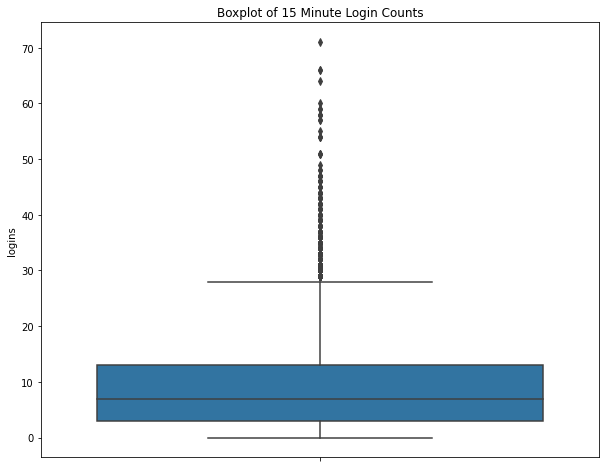

In [10]:
fig = plt.figure(figsize=(10,8))
sns.boxplot(y='logins', data=agg15_df)
plt.title('Boxplot of 15 Minute Login Counts')

plt.show()

One last thing to note is that there seem to be some outlying values, or periods of time with large spikes in demand. Let's quickly explore when they occured.

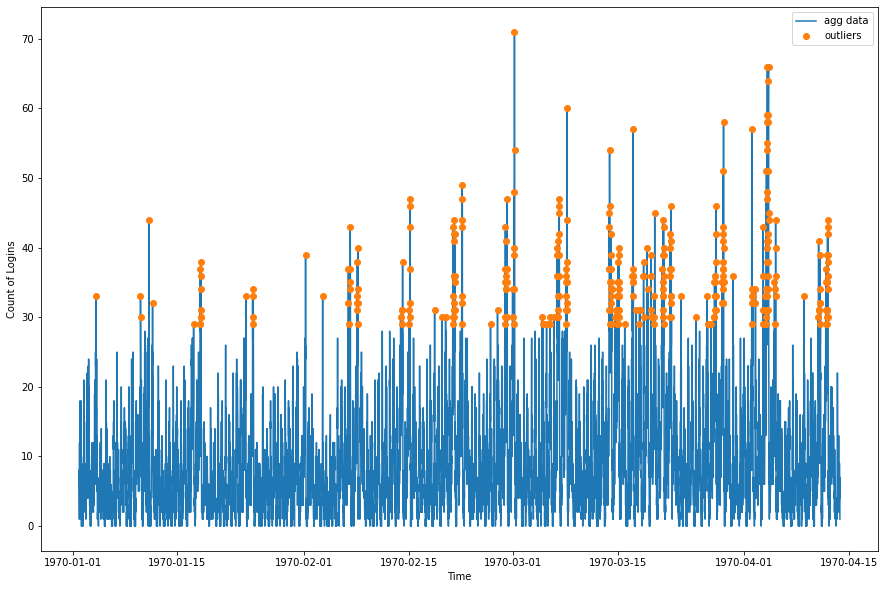

In [11]:
lower, upper = np.percentile(agg15_df, [25, 75])
IQR = upper - lower
outliers = agg15_df[agg15_df['logins'] > upper + 1.5*IQR]

fig = plt.figure(figsize=(15,10))                 
plt.plot(agg15_df.index, agg15_df, label='agg data')
plt.plot(outliers.index, outliers, marker='o', linestyle= ' ', label='outliers')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Count of Logins')

plt.show()

Yes we can conclude that the outliers are the tall spikes in demand.

# Part 2: Experiment & Metrics

1. The measure of success would be the number of driver partners that served Ultimate Gotham between 30% to 70% of the time in a given week, with Ultimate Metroplis receiving the compliment percentage. This is a good metric because the Ultimate managers want driver partners to serve more than one city and we want to make sure that the drivers do not make just one trip to another city. On the other hand a driver partner might serve a single city for a given day so a weekly percentage of time/ orders served needs to be considered.

2. 
    a. Assuming that there are many partner drivers, randomly select half of the drivers to receive the toll reimbursement and the other half do not. The drivers that will receive the reimbursement would have to be made aware that they will receive it. This method should eliminate any confounding that may occur with seasonality.  
    
    b. The null hypothesis would be that receiving a reimbursement does not increase the key metric. An A|B test would be performed to calculate the significance of the toll reimbursement program.  
   
    c. If the area under the overlap between the normal distributions of the means of the two groups is less than 0.05 then we would conclude that reimbursement encourages drivers to be availabe in both cities. The only caveat is that we do not know the impact of increasing the number of people willing to drive to other cities. If there is more competition the benefit might not be embraced by all drivers.

# Part 3: Predictive Modeling

## 1. Data Import, Cleaning & Analysis

In [63]:
user_data = pd.read_json('ultimate_data_challenge.json')

print('There are {} rows that are duplicates \n'.format(sum(user_data.duplicated())))
print(user_data.info())

There are 8 rows that are duplicates 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


After importing the data we can see there are three columns with missing data, 8 rows that are a duplicate of another row, and the dates are the wrong data type. Let's drop the duplicate rows, change the datatypes and then determine what to do with these missing values. After that we can look for any values that might be erroneous.

In [64]:
user_data.drop_duplicates(inplace=True)
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'], yearfirst=True)
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'], yearfirst=True)

avg_rating_by_driver basic statistics:
count    49791.000000
mean         4.778123
std          0.446679
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64


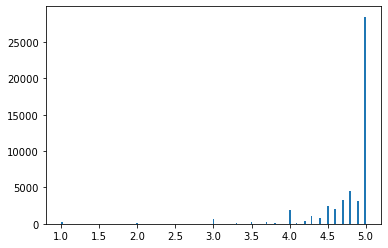

In [65]:
# For the average rating column only 201 entries are missing values
# Those rows could be eliminated or we can replace them with the average value
print('avg_rating_by_driver basic statistics:')
print(user_data['avg_rating_by_driver'].describe())

plt.hist(user_data['avg_rating_by_driver'], bins=int(np.sqrt(len(user_data))))
plt.show()

count    41873.000000
mean         4.601512
std          0.617360
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64


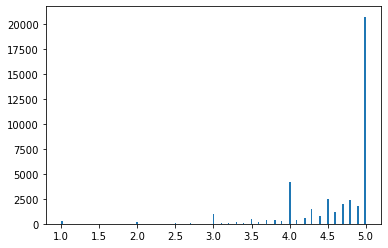

In [66]:
# Now we need to figure out what to do with the avg_rating_of_driver that has over 8000 missing values
print(user_data['avg_rating_of_driver'].describe())

plt.hist(user_data['avg_rating_of_driver'], bins=int(np.sqrt(len(user_data))))
plt.show()

The decision on what to do with avg_rating_of_driver missing values is difficult because approximately 16% of the values are missing. 16% is enough to impact the statistics of the values if a single value is used, but it also represents a significant amount of information loss if the rows are eliminated. Based on the distribution of values it would make the most sense to replace the missing values with the most frequent value, 5, instead of the average number for the avg_rating_of_driver and avg_rating_by_driver. As for the phone type, the missing values will be replaced with "other".

In [67]:
# For the phone type column let's fill in the missing values with "other"
user_data['phone'] = user_data['phone'].fillna('other')

user_data['avg_rating_by_driver'] = user_data['avg_rating_by_driver'].fillna(user_data['avg_rating_by_driver'].mode()[0])
user_data['avg_rating_of_driver'] = user_data['avg_rating_of_driver'].fillna(user_data['avg_rating_of_driver'].mode()[0])

Now lets look for errors in the data values by looking at the distribution.

In [68]:
user_data.describe(include='all')

<ipython-input-68-458ba8511da4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  user_data.describe(include='all')


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,49992,49992.000000,49992,49992.000000,49992.000000,49992,49992,49992.000000,49992,49992.000000,49992.00000,49992.000000
unique,3,NaN,31,NaN,NaN,182,3,NaN,2,NaN,NaN,NaN
top,Winterfell,NaN,2014-01-18 00:00:00,NaN,NaN,2014-06-29 00:00:00,iPhone,NaN,False,NaN,NaN,NaN
freq,23331,NaN,2944,NaN,NaN,2036,34578,NaN,31141,NaN,NaN,NaN
first,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2014-01-31 00:00:00,NaN,NaN,2014-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.278405,NaN,4.666229,1.074776,NaN,NaN,8.850952,NaN,60.929833,5.79726,4.779015
std,NaN,3.792953,NaN,0.583811,0.222352,NaN,NaN,19.960094,NaN,37.078229,5.70761,0.446001
min,NaN,0.000000,NaN,1.000000,1.000000,NaN,NaN,0.000000,NaN,0.000000,0.00000,1.000000
25%,NaN,0.000000,NaN,4.500000,1.000000,NaN,NaN,0.000000,NaN,33.300000,2.42000,4.700000


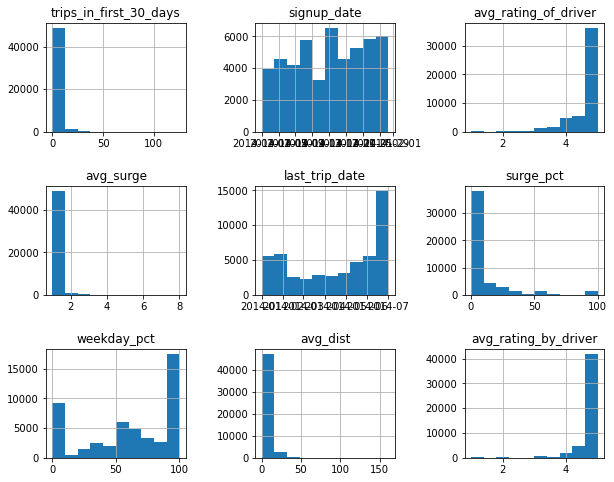

In [69]:
user_data.hist(figsize=(10,8))
plt.subplots_adjust(hspace=.5, wspace=.5);

Based on the distributions it seems like there may be some extreme outliers in the first 30 days trips, average surge, and average distance. Although unlikely, it is possible that someone could have taken around 3 trips a day, or someone took one long trip, and someone took one trip with an 8x surge. For now we will keep the values.

Next we need to calculate if the rider was retained by determining if they were active within the last 30 days. In this case we are assuming that it is anyone that took a trip within 30 days of the last date recorded.

In [70]:
import datetime as dt
user_data['retained'] = user_data['last_trip_date'] >= user_data['last_trip_date'].max() - dt.timedelta(days=30)

## 2. Model Building

The first thing we should do is some feature engineering with the signup date. We do not want to completely eliminate the column because there might be some important information, but having each day be a unique categorical value would be prone to overfitting. Let's extract the day of the week from the signup date instead and then drop the original column. We also will want to drop the last trip date column since it was used directly to calcualte our target variable.

In [88]:
user_data['signup_dow'] = user_data['signup_date'].dt.dayofweek
user_data_clean = user_data.drop(columns=['signup_date', 'last_trip_date'])

Now that the data is clean and our feature engineering is complete, we need to split into training and test data, then encode the categorical features and normalize the numeric values. We can do this all at once in our pipeline by using the ColumnTransformer method from sklearn.

In [94]:
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

y = user_data_clean['retained']
X = user_data_clean.drop(columns=['retained'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

cat_cols = ['city', 'phone', 'ultimate_black_user', 'signup_dow'] #categorical columns
num_cols = X.drop(columns=cat_cols).columns

encoder = OneHotEncoder()
norm = Normalizer()

transformer = ColumnTransformer([('cat_cols', encoder, cat_cols), ('num_cols', norm, num_cols)])

Now we need to do a quick model comparison to select the best model for this problem, before we start doing hyperparameter tuning.

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, cross_validate
import warnings

warnings.filterwarnings("ignore")

# Models for consideration
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier(use_label_encoder=False))
        ]

results = [] #list of model score values
names = [] #list of model names
scoring = ['accuracy', 'f1_weighted', 'roc_auc'] #scoring metrics

for name, model in models:
        pipe = Pipeline([('preprocess', transformer), ('model', model)])
        kfold = KFold(n_splits=3, shuffle=True, random_state=12)
        cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, scoring=scoring)
        
        results.append([cv_results[k].mean() for k in cv_results.keys()]) #average of score values of the 3 cross folds
        names.append(name)

results_df = pd.DataFrame(results, columns=cv_results.keys())
results_df['model'] = names
results_df.set_index('model', inplace=True)

[17:02:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Now that we built our models lets compare their performance. However, before we dive into the values it should be noted that 1. The Logistic Regression model did not converge, and 2. The model metrics values are not statistically robust because only 3 values were taken and the random state could impact performance. 

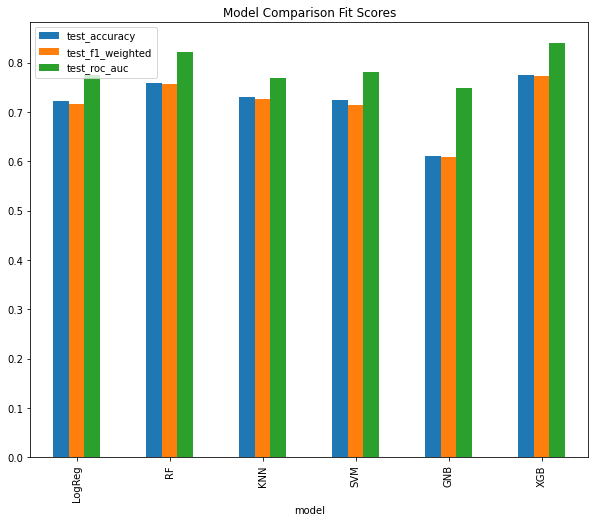

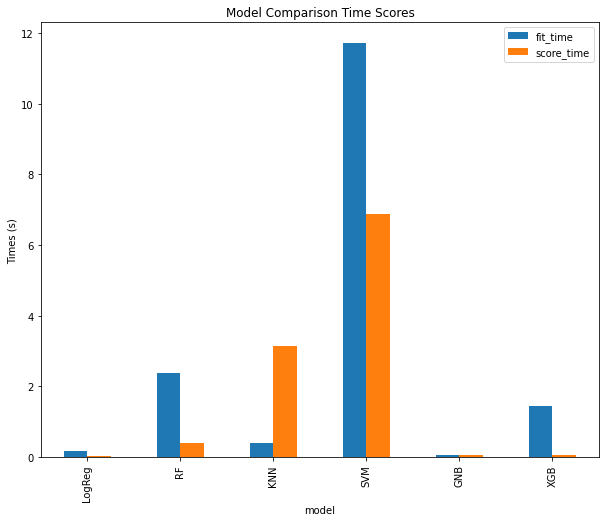

In [124]:
# first we can look at the fit scores
results_df.drop(columns=['fit_time', 'score_time']).plot.bar(figsize=(10,8))
plt.title('Model Comparison Fit Scores')

# Second we can look at the time scores
results_df.drop(columns=['test_accuracy', 'test_f1_weighted', 'test_roc_auc']).plot.bar(figsize=(10,8))
plt.title('Model Comparison Time Scores')
plt.ylabel('Times (s)')

plt.show()

From the two bar charts we can see that the XGBoost model had the highest fit scores in all of the categories, with RandomForest being in a close second. However, XGBoost had a loswer fit and score time compared to the random forest model so XGBoost will be the model we perform hyperparameter tuning on.

For the hyperparmeter tuning we will use the randomized search function instead of a grid search so we can better determine the impact of each parameter and increase the likelihood of finding a truly optimized set of parameter values.

In [130]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

X_train_trans = transformer.fit_transform(X_train)
estimator = XGBClassifier(verbosity=0)
param_dists = {'max_depth':[4,5,6,7,8,9,10], 'eta':uniform(), 'gamma':[0,5,10,15,20,25,30]}

rscv = RandomizedSearchCV(estimator=estimator, param_distributions=param_dists, scoring=scoring, refit='roc_auc')
rscv.fit(X_train_trans, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None,
                                           scal

In [136]:
print(rscv.best_score_)
print(rscv.best_params_)

0.8442878161185174
{'eta': 0.30332090199377537, 'gamma': 15, 'max_depth': 8}


We have now found our best parameters for the XGBoost classifier model, although it only resulted in a auc value slighlty better than what was found with the default values. Let's make one more model with those parameters and then use it to look at how well it works on the test data.

In [139]:
from sklearn.metrics import classification_report

model = XGBClassifier(max_depth=8, eta=0.3033, gamma=15, verbosity=0)
model.fit(X_train_trans, y_train)

X_test_trans = transformer.transform(X_test)
y_pred = model.predict(X_test_trans)
print(classification_report(y_test, y_pred, target_names=['not retained', 'retained']))

              precision    recall  f1-score   support

not retained       0.81      0.86      0.83      9382
    retained       0.74      0.66      0.70      5616

    accuracy                           0.79     14998
   macro avg       0.77      0.76      0.77     14998
weighted avg       0.78      0.79      0.78     14998



Overall the model seems to perform acceptable, but not great overall. The overall accuracy is faily good coming in at close to 80%, which is better than using random selection (50%). However, what the company really cares about is what makes a customer stay, and the model perfromance on the people that were retained is not very good. The bright side is that the threshold value can be tweaked, which will increase the predictive power on the ability train at the cost of poorly predicting if someone will stop using the service.

Let's now quickly look at the importance of the features for predicting if a user will continue using the service or not.

In [175]:
one_hot_names = np.concatenate(OneHotEncoder().fit(X_train[cat_cols]).categories_, axis=0)
feat_names = np.concatenate([one_hot_names, num_cols], axis=0)
feat_importance = pd.DataFrame(model.feature_importances_, index=feat_names, columns=['importance'])

feat_importance.sort_values('importance', ascending=False).head(10)

,importance
surge_pct,0.207091
King's Landing,0.191934
Android,0.119267
weekday_pct,0.087428
False,0.073191
iPhone,0.053746
Astapor,0.048268
avg_surge,0.042526
avg_rating_by_driver,0.035066
trips_in_first_30_days,0.027714


Looks like some of the top indicators for whether or not a customer will continue using the service is how much their surge charges were, where they live, the type of phone they use, and how often they use the service during a weekday. One concern that still lingers is how much impact the outlier surge_pct may have had on the feature importance, although it does make sense that having to pay a lot of money for a service makes a user not want to continue using the service.

## Part 3: What Next?

Now that the model has been created, Ultimate can use it to help retain customers. One way they could improve retention is by sending promotional materials to those they think will quit using their services. Alternatively, if surge pricing is a problem, they could provide greater incentive to driver partners to operate during the high demand times so the surge percentage is not as high.